In [1]:
import tensorflow as tf

import sys
sys.path.insert(0, '../fairml')
import plotting
import generate
import models
import actions
import utils

ModuleNotFoundError: No module named 'tensorflow'

# Generate the data

according to:

x ~ N((0,0), [[1, -0.5],[-0.5, 1]]) when Y == 0

x ~ N((1,1+z), [[1,0],[0,1]]) when Y == 1

where Z has a Gaussian prior z ~ N(0,1)

In [2]:
X, Y, Z = generate.generate_toys(4000)
plotting.plot_toy_variates(X, Y, Z)

/home/philipp/.local/lib/python3.5/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


In [3]:
# generate test data (a large, one time only thing)
n_test_samples = 100000

X, Y, Z = generate.generate_toys(n_test_samples)
X1, Y1, Z1 = generate.generate_toys(n_test_samples, z=1)
X0, Y0, Z0 = generate.generate_toys(n_test_samples, z=0)
X_1, Y_1, Z_1 = generate.generate_toys(n_test_samples, z=-1)

test_data = {}
test_data['all Z'] = X, Y, Z
test_data['Z=1'] = X1, Y1, Z1
test_data['Z=0'] = X0, Y0, Z0
test_data['Z=-1'] = X_1, Y_1, Z_1

# Train a classifier without the adversary

Trains a classifier f(X) that gives p(f(X)) which depends on Z, i.e. p(f(X)|Z=z). 

In [4]:
sess = tf.InteractiveSession()
ctr = 0

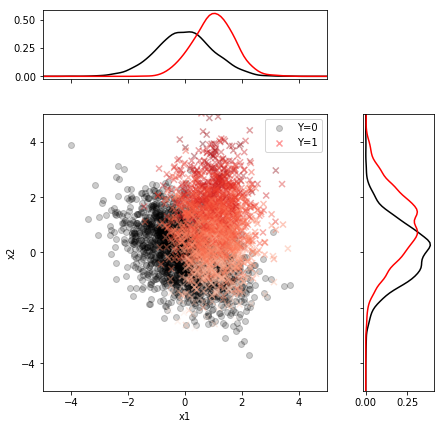

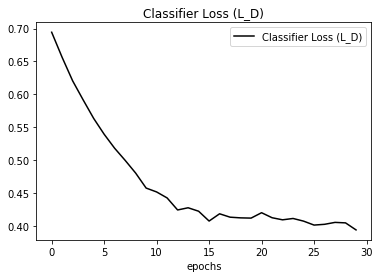

In [5]:
n_samples = 10000
n_epochs = 30
ctr+=1
name = 'name'+str(ctr)
    
# input placeholders
x_in = tf.placeholder(tf.float32, shape=(None, 2), name='X1_X2')
y_in = tf.placeholder(tf.float32, shape=(None, ), name='Y')
z_in = tf.placeholder(tf.float32, shape=(None, ), name='Z')
inputs = [x_in, y_in, z_in]

# create the classifier graph, loss, and optimisation
clf_output, vars_D = models.classifier(x_in, name)
loss_D = models.classifier_loss(clf_output, y_in)
opt_D = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss_D, var_list=vars_D)

# train the classifier
sess.run(tf.global_variables_initializer())
actions.train(sess, opt_D, loss_D, inputs, generate.generate_toys, n_samples, n_epochs, 'Classifier Loss (L_D)')

# plot the performance of the classifier
pred = utils.sigmoid(sess.run(clf_output, feed_dict={x_in:X, y_in:Y}))
pred1 = utils.sigmoid(sess.run(clf_output, feed_dict={x_in:X1, y_in:Y1}))
pred0 = utils.sigmoid(sess.run(clf_output, feed_dict={x_in:X0, y_in:Y0}))
pred_1 = utils.sigmoid(sess.run(clf_output, feed_dict={x_in:X_1, y_in:Y_1}))
test_data['preds'] = pred, pred1, pred0, pred_1
#plotting.plot_classifier_performance(test_data, 'media/plots/classifier')

# Adversarial training (GaussMix)

Train adversarially against GaussMix adversary (same as pivoting paper).

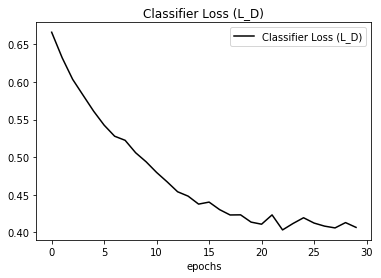

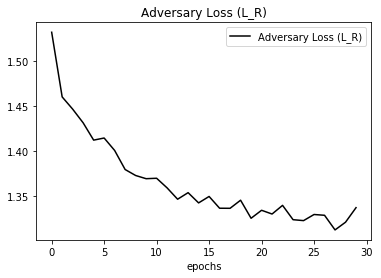

15/50
20/50
25/50
30/50
35/50
40/50
45/50


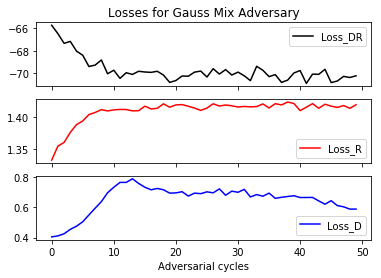

In [6]:
n_samples = 10000
n_epochs = 30
n_adv_cycles = 50
n_components = 5
n_clf = 1
n_adv = 5
lam = 50
ctr+=1
name = 'name'+str(ctr)
    
# input placeholders
x_in = tf.placeholder(tf.float32, shape=(None, 2), name='X12')
y_in = tf.placeholder(tf.float32, shape=(None, ), name='Y')
z_in = tf.placeholder(tf.float32, shape=(None, ), name='Z')
inputs = [x_in, y_in, z_in]

# create the classifier graph, loss, and optimisation
clf_output, vars_D = models.classifier(x_in, name+'_clf')
loss_D = models.classifier_loss(clf_output, y_in)
opt_D = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss_D, var_list=vars_D)

# create the adversary graph, loss, and optimisation
adv_output, vars_R = models.adversary_gaussmix(clf_output, n_components, name+'_adv')
loss_R = models.adversary_gaussmix_loss(z_in, adv_output, n_components)
opt_R = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss_R, var_list=vars_R)

# create the combined loss function (for the classifier)
loss_DR = loss_D - lam*loss_R
opt_DR = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss_DR, var_list=vars_D)

# initialise the variables
sess.run(tf.global_variables_initializer())

# pretrain the classifier
actions.train(sess, opt_D, loss_D, inputs, generate.generate_toys, n_samples, n_epochs, 'Classifier Loss (L_D)')

# pretrain the adversary
actions.train(sess, opt_R, loss_R, inputs, generate.generate_toys, n_samples, n_epochs, 'Adversary Loss (L_R)')

# now do the adversarial part (modifed loss function for the classifier)
losses = [loss_D, loss_R, loss_DR]
opts = [None, opt_R, opt_DR]
actions.train_adversarially(sess, losses, opts, inputs, generate.generate_toys, n_samples, n_adv_cycles, n_clf, n_adv, 'Gauss Mix')

# plot the performance of the classifier
pred = utils.sigmoid(sess.run(clf_output, feed_dict={x_in:X, y_in:Y}))
pred1 = utils.sigmoid(sess.run(clf_output, feed_dict={x_in:X1, y_in:Y1}))
pred0 = utils.sigmoid(sess.run(clf_output, feed_dict={x_in:X0, y_in:Y0}))
pred_1 = utils.sigmoid(sess.run(clf_output, feed_dict={x_in:X_1, y_in:Y_1}))
test_data['preds'] = pred, pred1, pred0, pred_1
#plotting.plot_classifier_performance(test_data, 'media/plots/classifier_GaussMixAdv')


# Adversarial training (MINE)

Train adversarially against MINE adversary.

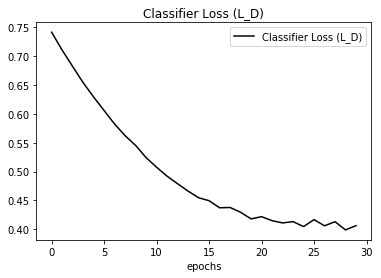

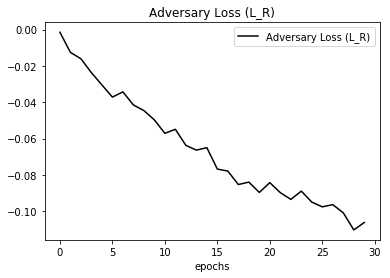

15/50
20/50
25/50
30/50
35/50
40/50
45/50


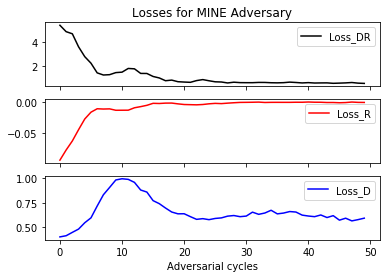

In [7]:
n_samples = 10000
n_epochs = 30
n_adv_cycles = 50
n_components = 5
n_clf = 1
n_adv = 5
lam = 50
ctr+=1
name = 'name'+str(ctr)

# input placeholders
x_in = tf.placeholder(tf.float32, shape=(None, 2), name='X12')
y_in = tf.placeholder(tf.float32, shape=(None, ), name='Y')
z_in = tf.placeholder(tf.float32, shape=(None, ), name='Z')
inputs = [x_in, y_in, z_in]

# create the classifier graph, loss, and optimisation
clf_output, vars_D = models.classifier(x_in, name+'_clf')
loss_D = models.classifier_loss(clf_output, y_in)
opt_D = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss_D, var_list=vars_D)

# create the adversary graph, loss, and optimisation
T_xy, T_x_y, vars_R = models.MINE(clf_output, z_in, name+'_adv', deep=True)
loss_R = models.MINE_loss(T_xy, T_x_y)
opt_R = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss_R, var_list=vars_R)

# create the combined loss function (for the classifier)
loss_DR = loss_D - lam*loss_R
opt_DR = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss_DR, var_list=vars_D)

# initialise the variables
sess.run(tf.global_variables_initializer())

# pretrain the classifier
actions.train(sess, opt_D, loss_D, inputs, generate.generate_toys, n_samples, n_epochs, 'Classifier Loss (L_D)')

# pretrain the adversary
actions.train(sess, opt_R, loss_R, inputs, generate.generate_toys, n_samples, n_epochs, 'Adversary Loss (L_R)')

# now do the adversarial part (modifed loss function for the classifier)
losses = [loss_D, loss_R, loss_DR]
opts = [None, opt_R, opt_DR]
actions.train_adversarially(sess, losses, opts, inputs, generate.generate_toys, n_samples, n_adv_cycles, n_clf, n_adv, 'MINE')

# plot the performance of the classifier
pred = utils.sigmoid(sess.run(clf_output, feed_dict={x_in:X, y_in:Y}))
pred1 = utils.sigmoid(sess.run(clf_output, feed_dict={x_in:X1, y_in:Y1}))
pred0 = utils.sigmoid(sess.run(clf_output, feed_dict={x_in:X0, y_in:Y0}))
pred_1 = utils.sigmoid(sess.run(clf_output, feed_dict={x_in:X_1, y_in:Y_1}))
test_data['preds'] = pred, pred1, pred0, pred_1
#plotting.plot_classifier_performance(test_data, 'media/plots/classifier_MINE')